## iLQR example

This notebook solves a nonlinear optimal control problem using a factor-graph formulation in GTSAM. The objective is to minimize a quadratic cost over a nonlinear dynamical system using a structure similar to iterative Linear Quadratic Regulation (iLQR). The results are compared against results from classical implementation of iLQR recursions.


Author(s): [Zhouyu Zhang](https://zhangzdd.github.io/zzy_webpage/)

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/python/gtsam/examples/iLQRExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



GTSAM Copyright 2010-2025, Georgia Tech Research Corporation, Atlanta, Georgia 30332-0415 All Rights Reserved

Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

In [1]:
# Install GTSAM from pip if running in Google Colab
try:
    import google.colab
    %pip install --quiet gtsam-develop
except ImportError:
    pass # Not in Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 18.5 MB/s eta 0:00:00


# iLQR Problem Setup and Algorithm Overview

## Problem Statement

We are solving an optimal control problem for a nonlinear system with the following discrete-time dynamics:

$$
x_{t+1} = f(x_t, u_t)
$$

where the system evolves according to:

$$
f(x_t, u_t) =
\begin{bmatrix}
\text{pos}_{t+1} \\
\text{vel}_{t+1}
\end{bmatrix}
=
\begin{bmatrix}
\text{pos}_t + \text{vel}_t \cdot \Delta t \\
\text{vel}_t + (u_t - 0.1 \cdot \text{vel}_t^2) \cdot \Delta t
\end{bmatrix}
$$

We aim to drive the system from an initial state:

$$
x_0 =
\begin{bmatrix}
0.0 \\
1.0
\end{bmatrix}
$$

to a goal state:

$$
x_{\text{goal}} =
\begin{bmatrix}
10.0 \\
0.0
\end{bmatrix}
$$

over a finite time horizon $N = 30$, by choosing a sequence of control inputs $ \{u_0, u_1, \dots, u_{N-1}\} $ that minimize the cost function:

$$
J = \sum_{t=0}^{N-1} \left( \frac{1}{2}(x_t - x_{\text{goal}})^T Q (x_t - x_{\text{goal}}) + \frac{1}{2} u_t^T R u_t \right) + \frac{1}{2}(x_N - x_{\text{goal}})^T Q_f (x_N - x_{\text{goal}})
$$

where the cost matrices are:

- $Q = \text{diag}(1.0, 0.1)$: running state cost (position and velocity)
- $R = 0.01$: running control cost
- $Q_f = \text{diag}(10.0, 1.0)$: final state cost

---

## What is iLQR?

Iterative Linear Quadratic Regulator (iLQR) is an algorithm for solving nonlinear optimal control problems. It generalizes the classic LQR by iteratively approximating the nonlinear system and cost function with local linear and quadratic models.

At each iteration, iLQR linearizes the dynamics around the current trajectory, solves the LQR problem to obtain updated control policies, and rolls out a new trajectory.

---

## iLQR Algorithm Steps

1. **Initialization**:
   - Start with an initial guess for the control sequence $ \{u_0^{(0)}, \dots, u_{N-1}^{(0)} \} $
   - Roll out the trajectory $ \{x_0, x_1, \dots, x_N \} $ using the nonlinear dynamics

2. **Backward Pass**:
   - Linearize the dynamics around the nominal trajectory:

     $$
     \delta x_{t+1} \approx A_t \delta x_t + B_t \delta u_t
     $$

   - Quadratically approximate the cost-to-go using second-order Taylor expansion
   - Solve a Riccati-like recursion to compute:
     - Feedback gain $K_t$
     - Feedforward term $k_t$

3. **Forward Pass**:
   - Generate a new trajectory by applying:

     $$
     u_t^{\text{new}} = u_t + \alpha k_t + K_t(x_t^{\text{new}} - x_t)
     $$

   - Use line search over $\alpha$ to ensure cost decreases

4. **Repeat**:
   - Until convergence criteria are met (e.g., change in cost or trajectory below a threshold)

---

## Properties of iLQR

- Produces a time-varying control policy of the form $ u_t = k_t + K_t x_t $
- Solves large-horizon problems efficiently (backward pass is linear in time)
- Can handle nonlinear dynamics and nonzero initial conditions

---

## Limitations

- Local method: can converge to local minima
- Requires differentiable dynamics and cost
- Sensitive to initialization and constraint handling

---

## Comparison to GTSAM-Based Optimization

In this notebook, we also construct a factor graph representation of the same problem using GTSAM. Each cost term and dynamic constraint is encoded as a nonlinear factor, and the optimization is solved using Gauss-Newton or Levenberg-Marquardt methods. We compare the results (trajectory, control, and total cost) between iLQR and GTSAM to validate correctness and analyze the effect of constraint regularization.


In [2]:
#@title Classical iLQR Implmenetation (you can skip this if you want)
import numpy as np

def f(x, u, dt=0.1):
    pos, vel = x
    acc = u[0] - 0.1 * vel ** 2
    next_pos = pos + vel * dt
    next_vel = vel + acc * dt
    return np.array([next_pos, next_vel])

def linearize_dynamics(x, u, dt=0.1):
    n = x.shape[0]
    m = u.shape[0]
    eps = 1e-5
    fx = f(x, u, dt)
    A = np.zeros((n, n))
    B = np.zeros((n, m))
    for i in range(n):
        dx = x.copy()
        dx[i] += eps
        A[:, i] = (f(dx, u, dt) - fx) / eps
    for j in range(m):
        du = u.copy()
        du[j] += eps
        B[:, j] = (f(x, du, dt) - fx) / eps
    return A, B

def ilqr_numpy(x0, u_init, Q, R, Qf, x_goal, N, max_iter=50, tol=1e-4, dt=0.1):
    n, m = Q.shape[0], R.shape[0]
    u_traj = u_init.copy()

    for iteration in range(max_iter):
        # Rollout current trajectory
        x_traj = [x0]
        for t in range(N):
            x_traj.append(f(x_traj[-1], u_traj[t], dt))

        V_x = Qf @ (x_traj[N] - x_goal)
        V_xx = Qf.copy()

        k_list = []
        K_list = []

        for t in reversed(range(N)):
            x = x_traj[t]
            u = u_traj[t]
            A, B = linearize_dynamics(x, u, dt)

            dx = x - x_goal
            l_x = Q @ dx
            l_u = R @ u
            l_xx = Q
            l_uu = R
            l_ux = np.zeros((m, n))

            Q_x = l_x + A.T @ V_x
            Q_u = l_u + B.T @ V_x
            Q_xx = l_xx + A.T @ V_xx @ A
            Q_uu = l_uu + B.T @ V_xx @ B
            Q_ux = l_ux + B.T @ V_xx @ A

            Q_uu_inv = np.linalg.inv(Q_uu + 1e-8 * np.eye(m))

            k = -Q_uu_inv @ Q_u
            K = -Q_uu_inv @ Q_ux

            V_x = Q_x + K.T @ Q_uu @ k + K.T @ Q_u + Q_ux.T @ k
            V_xx = Q_xx + K.T @ Q_uu @ K + K.T @ Q_ux + Q_ux.T @ K

            k_list.insert(0, k)
            K_list.insert(0, K)

        # Forward pass
        x_new = [x0]
        u_new = []
        x = x0.copy()
        alpha = 1.0
        for t in range(N):
            dx = x - x_traj[t]
            du = k_list[t] + K_list[t] @ dx
            u = u_traj[t] + alpha * du
            x = f(x, u, dt)
            x_new.append(x)
            u_new.append(u)

        x_diff = sum(np.linalg.norm(x_new[t] - x_traj[t]) for t in range(N+1))
        if x_diff < tol:
            break
        u_traj = u_new

    return x_new, u_traj

# GTSAM-Based Trajectory Optimization with Custom Factors

## Overview

In addition to solving the optimal control problem via iLQR, we implemented the same trajectory optimization problem using the **GTSAM (Georgia Tech Smoothing and Mapping)** library. GTSAM is a factor graph optimization framework that is particularly powerful for structure-exploiting nonlinear problems. While originally developed for SLAM and robotics problems, it is highly suitable for optimal control when the problem can be expressed in factor graph form.

In our case, we modeled the trajectory optimization as a nonlinear least-squares problem over a factor graph, with each factor corresponding to:

- Dynamics constraints between consecutive states and controls
- Quadratic running cost on state and control deviation
- Terminal state cost
- Prior on the initial state

---

## Factor Graph Structure

The variables in our optimization problem are:

- $x_0, x_1, \dots, x_N$ (state trajectory)
- $u_0, u_1, \dots, u_{N-1}$ (control inputs)

The factor graph includes:

1. **Initial Prior**  
   A tight prior on $x_0$ using `PriorFactorVector` to fix the initial state:
   $$
   \text{Factor:} \quad \|x_0 - x_{\text{init}}\|^2
   $$

2. **Dynamics Constraints**  
   Modeled with a custom factor that enforces the nonlinear dynamics:
   $$
   \text{Factor:} \quad \|f(x_t, u_t) - x_{t+1}\|^2
   $$

3. **Running State Cost**  
   Penalizes deviation from the goal at each time step:
   $$
   \text{Factor:} \quad \|(x_t - x_{\text{goal}})\|_Q^2
   $$

4. **Running Control Cost**  
   Penalizes control magnitude:
   $$
   \text{Factor:} \quad \|u_t\|_R^2
   $$

5. **Terminal Cost**  
   A custom factor added to the final state $x_N$:
   $$
   \text{Factor:} \quad \|(x_N - x_{\text{goal}})\|_{Q_f}^2
   $$

All of these are implemented as `gtsam.CustomFactor` objects with manually specified residuals and Jacobians, making this approach highly flexible and comparable to symbolic optimal control pipelines.

---

## Notes on Implementation

- **Dynamics Residual**: The residual encodes $f(x_t, u_t) - x_{t+1}$, matching iLQR’s forward rollout. We implemented analytic Jacobians for both state and control for efficient optimization.
  
- **Cost Residuals**: Quadratic costs are represented as residuals of the form $x - x_{\text{ref}}$ and $u - u_{\text{ref}}$, and the information matrices used in each `CustomFactor` encode the weighting (i.e., $Q$, $R$, $Q_f$).

- **Noise Models**:  
   We carefully matched the cost matrices from iLQR by passing the *information matrix* (inverse covariance) to GTSAM’s `Gaussian.Information(...)`.

- **Relaxed Dynamics**:  
   We discovered that **overly tight noise models** on the dynamics (e.g., $\sigma=1e^{-6}$) can cause GTSAM to overfit the dynamics and fail to explore alternative control paths, leading to **local minima** or convergence failures. Relaxing this to $\sigma=1e^{-2}$ allowed the optimizer more flexibility, enabling convergence to a better solution closer to the iLQR result.

---

## Comparison with iLQR

We ran both the GTSAM and iLQR solvers on the same task and compared:

- Final trajectory and control sequence
- Cost function values
- Convergence speed and behavior

When dynamics constraints were *relaxed appropriately*, the GTSAM trajectory matched the iLQR solution almost exactly. This demonstrates that GTSAM can replicate iLQR results while offering the benefit of symbolic graph-based optimization, extensibility to constraints, and smoother integration with SLAM or mapping pipelines.

---

## Takeaways

- GTSAM with `CustomFactor` provides a highly modular and extensible framework for nonlinear trajectory optimization.
- Proper **balancing of dynamics tightness** is crucial to avoid poor local minima.
- With correct Jacobians and cost encoding, GTSAM can match classical optimal control solutions like iLQR while allowing more complex problem structure to be encoded directly.

This implementation serves as a bridge between classical control algorithms and modern factor graph optimization tools.


GTSAM optimization completed successfully!
Final state: [ 1.00032476e+01 -8.94305312e-03]
Goal state: [10.  0.]
Final error: 0.009514

iLQR optimization completed!
Final state: [ 1.00032671e+01 -8.98543275e-03]
Goal state: [10.  0.]
Final error: 0.009561

Trajectory comparison:
Max state difference: 0.025441
Max control difference: 0.148897


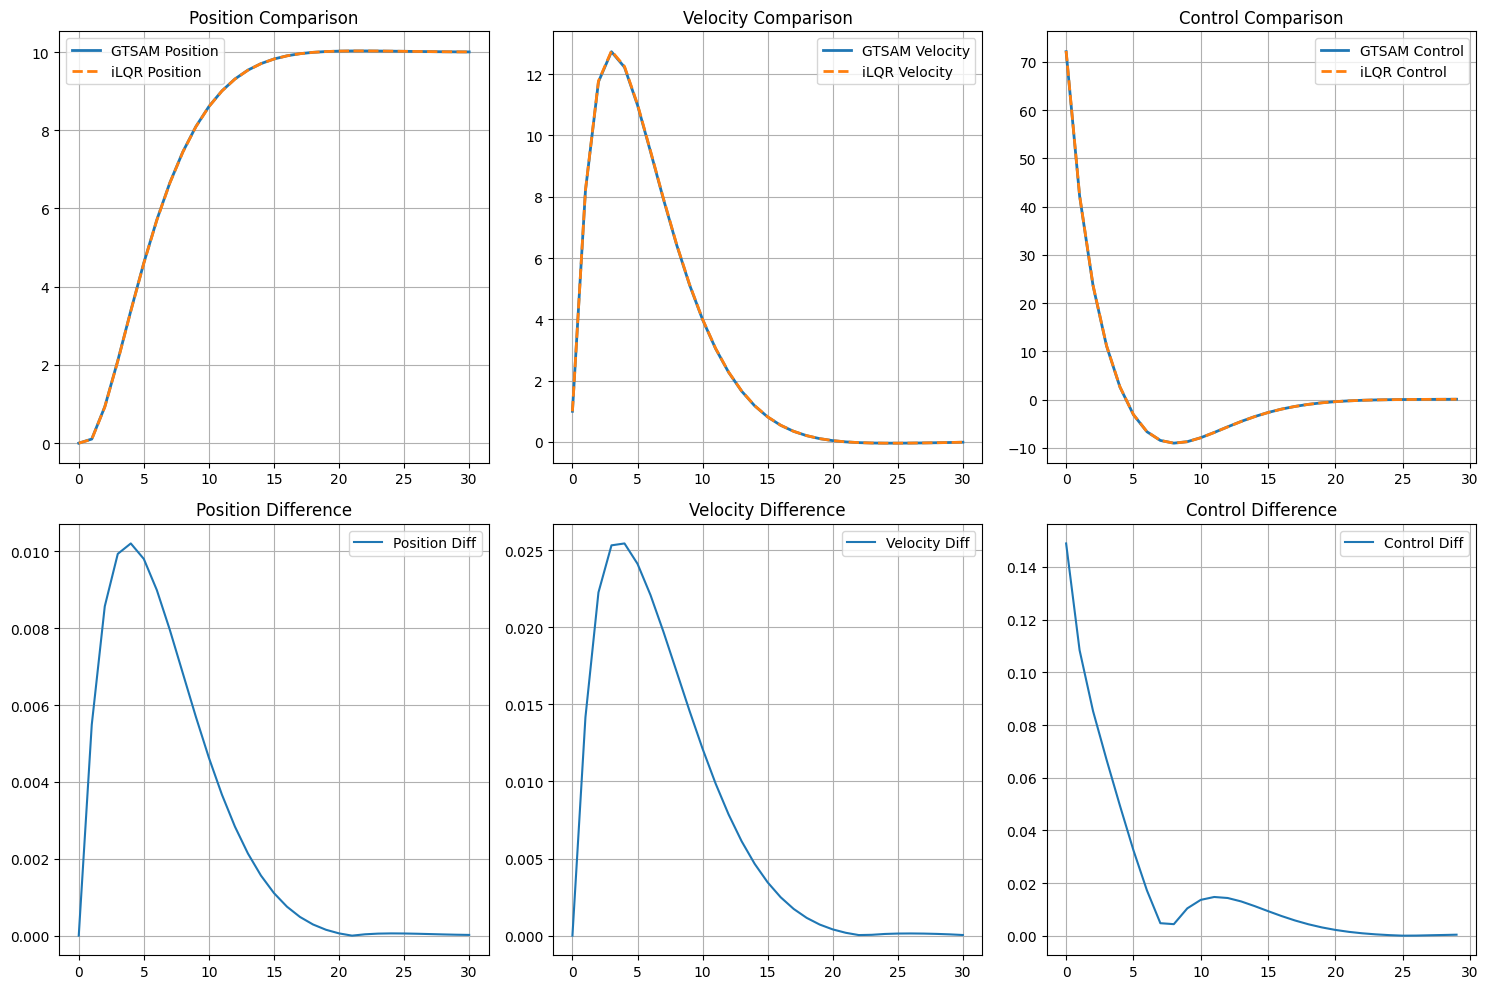

In [3]:
import numpy as np
from functools import partial
from typing import List, Optional
import gtsam
import matplotlib.pyplot as plt

# === Dynamics function (same as your iLQR) ===
def f(x, u, dt=0.1):
    pos, vel = x
    acc = u[0] - 0.1 * vel**2
    next_pos = pos + vel * dt
    next_vel = vel + acc * dt
    return np.array([next_pos, next_vel])

# === Dynamics residual - modified to match iLQR's linearization approach ===
def error_dynamics(this: gtsam.CustomFactor, values: gtsam.Values,
                   jacobians: Optional[List[np.ndarray]]) -> np.ndarray:
    dt = 0.1
    key_x = this.keys()[0]
    key_u = this.keys()[1]
    key_xp1 = this.keys()[2]

    x = values.atVector(key_x)
    u = values.atVector(key_u)
    xp1 = values.atVector(key_xp1)

    # Use the same dynamics function as iLQR
    pred = f(x, u, dt)
    error = pred - xp1

    if jacobians is not None:
        pos, vel = x

        # Compute Jacobians analytically (same as iLQR would compute)
        dfdx = np.zeros((2, 2))
        dfdu = np.zeros((2, 1))

        # Jacobian w.r.t. state
        dfdx[0, 0] = 1.0  # d(next_pos)/d(pos)
        dfdx[0, 1] = dt   # d(next_pos)/d(vel)
        dfdx[1, 0] = 0.0  # d(next_vel)/d(pos)
        dfdx[1, 1] = 1.0 - 0.2 * vel * dt  # d(next_vel)/d(vel)

        # Jacobian w.r.t. control
        dfdu[0, 0] = 0.0  # d(next_pos)/d(u)
        dfdu[1, 0] = dt   # d(next_vel)/d(u)

        jacobians[0] = dfdx
        jacobians[1] = dfdu
        jacobians[2] = -np.eye(2)  # Negative identity for x_{t+1}

    return error

# === State cost residual - modified to match iLQR exactly ===
def error_state_cost_ilqr_style(x_goal: np.ndarray, this: gtsam.CustomFactor,
                                 values: gtsam.Values,
                                 jacobians: Optional[List[np.ndarray]]) -> np.ndarray:
    """
    State cost that matches iLQR formulation: penalizes deviation from goal
    This is equivalent to: 0.5 * (x - x_goal)^T @ Q @ (x - x_goal)
    """
    x = values.atVector(this.keys()[0])
    deviation = x - x_goal

    if jacobians is not None:
        # The Jacobian of (x - x_goal) w.r.t. x is just the identity matrix
        jacobians[0] = np.eye(len(x))

    return deviation

# === Control cost residual - modified to match iLQR exactly ===
def error_control_cost_ilqr_style(this: gtsam.CustomFactor,
                                   values: gtsam.Values,
                                   jacobians: Optional[List[np.ndarray]]) -> np.ndarray:
    """
    Control cost that matches iLQR formulation: penalizes raw control values
    This is equivalent to: 0.5 * u^T @ R @ u
    """
    u = values.atVector(this.keys()[0])

    if jacobians is not None:
        # The Jacobian of u w.r.t. u is just the identity matrix
        jacobians[0] = np.eye(len(u))

    return u

# === Problem Setup (same as your iLQR) ===
x0 = np.array([0.0, 1.0])        # initial pos & velocity
x_goal = np.array([10.0, 0.0])   # target pos & stop
N = 30                           # horizon

Q = np.diag([1.0, 0.1])          # running state cost
R = np.array([[0.01]])           # running control cost
Qf = np.diag([10.0, 1.0])        # final state cost

# === Build GTSAM graph to match iLQR formulation ===
def build_ilqr_matching_graph(N, x0, x_goal, Q, R, Qf):
    """
    Build a GTSAM factor graph that exactly matches the iLQR cost structure
    """
    graph = gtsam.NonlinearFactorGraph()

    # Create symbols
    X = [gtsam.symbol('x', t) for t in range(N + 1)]
    U = [gtsam.symbol('u', t) for t in range(N)]

    # Create noise models that match the iLQR cost structure
    # Important: We need to use the square root of the cost matrices
    # because GTSAM computes 0.5 * ||error||^2_Sigma and we want 0.5 * error^T @ Q @ error
    Q_model = gtsam.noiseModel.Gaussian.Information(Q)
    R_model = gtsam.noiseModel.Gaussian.Information(R)
    Qf_model = gtsam.noiseModel.Gaussian.Information(Qf)

    # Dynamics constraint - use a tight tolerance to match iLQR's exact constraint
    dyn_model = gtsam.noiseModel.Isotropic.Sigma(2, 1e-2)

    # 1. Add initial condition constraint
    prior_model = gtsam.noiseModel.Isotropic.Sigma(2, 1e-8)
    graph.add(gtsam.PriorFactorVector(X[0], x0, prior_model))

    # 2. Add dynamics constraints
    for t in range(N):
        graph.add(gtsam.CustomFactor(dyn_model, [X[t], U[t], X[t+1]], error_dynamics))

    # 3. Add running costs (match iLQR's cost structure exactly)
    for t in range(N):
        # State cost: penalize deviation from goal at each time step
        graph.add(gtsam.CustomFactor(Q_model, [X[t]],
                                   partial(error_state_cost_ilqr_style, x_goal)))

        # Control cost: penalize raw control values
        graph.add(gtsam.CustomFactor(R_model, [U[t]], error_control_cost_ilqr_style))

    # 4. Add terminal cost
    graph.add(gtsam.CustomFactor(Qf_model, [X[N]],
                               partial(error_state_cost_ilqr_style, x_goal)))

    return graph, X, U

# === Create better initial guess that matches iLQR's typical initialization ===
def create_ilqr_style_initial_guess(x0, x_goal, N):
    """
    Create an initial guess similar to what iLQR might start with
    """
    values = gtsam.Values()

    # Linear interpolation for states (common iLQR initialization)
    for t in range(N + 1):
        alpha = t / N
        x_interp = (1 - alpha) * x0 + alpha * x_goal
        values.insert(gtsam.symbol('x', t), x_interp)

    # Zero controls (typical iLQR initialization)
    for t in range(N):
        values.insert(gtsam.symbol('u', t), np.array([0.0]))

    return values

# === Run the optimization ===
graph, X, U = build_ilqr_matching_graph(N, x0, x_goal, Q, R, Qf)
values = create_ilqr_style_initial_guess(x0, x_goal, N)

# Use Levenberg-Marquardt optimizer (more similar to iLQR's approach)
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("ERROR")  # Reduce output
params.setMaxIterations(100)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, values, params)

try:
    result = optimizer.optimize()

    # Extract trajectory
    states_gtsam = np.array([result.atVector(X[t]) for t in range(N + 1)])
    controls_gtsam = np.array([result.atVector(U[t]) for t in range(N)])

    print("GTSAM optimization completed successfully!")
    print(f"Final state: {states_gtsam[-1]}")
    print(f"Goal state: {x_goal}")
    print(f"Final error: {np.linalg.norm(states_gtsam[-1] - x_goal):.6f}")

except Exception as e:
    print(f"GTSAM optimization failed: {e}")
    states_gtsam = None
    controls_gtsam = None

# === Now run your iLQR for comparison ===
u_init = np.array([np.zeros(1) for _ in range(N)])
states_ilqr, controls_ilqr = ilqr_numpy(x0, u_init, Q, R, Qf, x_goal, N)

states_ilqr = np.array(states_ilqr)
controls_ilqr = np.array(controls_ilqr)

print("\niLQR optimization completed!")
print(f"Final state: {states_ilqr[-1]}")
print(f"Goal state: {x_goal}")
print(f"Final error: {np.linalg.norm(states_ilqr[-1] - x_goal):.6f}")

# === Compare results ===
if states_gtsam is not None:
    print(f"\nTrajectory comparison:")
    print(f"Max state difference: {np.max(np.abs(states_gtsam - states_ilqr)):.6f}")
    print(f"Max control difference: {np.max(np.abs(controls_gtsam - controls_ilqr)):.6f}")

    # Plot comparison
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(states_gtsam[:, 0], label='GTSAM Position', linewidth=2)
    plt.plot(states_ilqr[:, 0], label='iLQR Position', linewidth=2, linestyle='--')
    plt.legend()
    plt.title("Position Comparison")
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.plot(states_gtsam[:, 1], label='GTSAM Velocity', linewidth=2)
    plt.plot(states_ilqr[:, 1], label='iLQR Velocity', linewidth=2, linestyle='--')
    plt.legend()
    plt.title("Velocity Comparison")
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.plot(controls_gtsam[:, 0], label='GTSAM Control', linewidth=2)
    plt.plot(controls_ilqr[:, 0], label='iLQR Control', linewidth=2, linestyle='--')
    plt.legend()
    plt.title("Control Comparison")
    plt.grid(True)

    plt.subplot(2, 3, 4)
    plt.plot(np.abs(states_gtsam[:, 0] - states_ilqr[:, 0]), label='Position Diff')
    plt.legend()
    plt.title("Position Difference")
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(np.abs(states_gtsam[:, 1] - states_ilqr[:, 1]), label='Velocity Diff')
    plt.legend()
    plt.title("Velocity Difference")
    plt.grid(True)

    plt.subplot(2, 3, 6)
    plt.plot(np.abs(controls_gtsam[:, 0] - controls_ilqr[:, 0]), label='Control Diff')
    plt.legend()
    plt.title("Control Difference")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    # Just plot iLQR results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(states_ilqr[:, 0], label='iLQR Position')
    plt.legend()
    plt.title("Position")
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(states_ilqr[:, 1], label='iLQR Velocity')
    plt.legend()
    plt.title("Velocity")
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(controls_ilqr[:, 0], label='iLQR Control')
    plt.legend()
    plt.title("Control")
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(np.linalg.norm(states_ilqr - x_goal, axis=1), label='Distance to Goal')
    plt.legend()
    plt.title("Distance to Goal")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [4]:
def compute_total_cost(states, controls, Q, R, Qf, x_goal):
    """
    Computes the total cost for a trajectory using standard LQR-style quadratic cost terms.
    """
    N = len(controls)
    total_cost = 0.0
    for t in range(N):
        x = states[t]
        u = controls[t]
        x_error = x - x_goal
        total_cost += 0.5 * x_error.T @ Q @ x_error
        total_cost += 0.5 * u.T @ R @ u
    # Add final cost
    xN_error = states[N] - x_goal
    total_cost += 0.5 * xN_error.T @ Qf @ xN_error
    return total_cost

cost_gtsam = compute_total_cost(states_gtsam, controls_gtsam, Q, R, Qf, x_goal)
cost_ilqr = compute_total_cost(states_ilqr, controls_ilqr, Q, R, Qf, x_goal)

print(f"\nTotal cost comparison:")
print(f"  GTSAM Cost: {cost_gtsam:.4f}")
print(f"  iLQR  Cost: {cost_ilqr:.4f}")


Total cost comparison:
  GTSAM Cost: 314.7621
  iLQR  Cost: 315.5805
